In [1]:
from Models import Get_data as Gd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from Models.CAE import Encoder, Decoder, Autoencoder
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from tqdm import tqdm

In [2]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [3]:
directory = '/home/wl4023/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

# CAE

## Create Dataset for CAE

### Use all the case

In [4]:
dataset, length = Gd.get_all_nodes(folders[:-1])

train_np, val_np = train_test_split(dataset, test_size=0.2, shuffle=True)
train_np = np.expand_dims(train_np[:, :, 0], axis=2)
val_np = np.expand_dims(val_np[:, :, 0], axis=2)

In [5]:
train_tensor = torch.tensor(train_np, dtype=torch.float).permute(0, 2, 1)
train_tensor_set = Gd.MyDataset(train_tensor)

In [6]:
val_tensor = torch.tensor(val_np, dtype=torch.float).permute(0, 2, 1)
val_tensor_set = Gd.MyDataset(val_tensor)

In [7]:
train_loader = DataLoader(train_tensor_set, batch_size=5, shuffle=True)
val_loader = DataLoader(val_tensor_set, batch_size=5, shuffle=True)

In [8]:
preprocessor = Gd.Preprocessor()
preprocessor.fit(torch.concat((train_tensor, val_tensor), axis=0))
preprocessor.mean

tensor(6.9571)

### Test set

In [9]:
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = np.expand_dims(test_np[:, :, 0], axis=2)

In [10]:
print(folders[-1:])

['/home/wl4023/data/Sibo_22Mar2024/case_23/hessian_']


In [11]:
test_tensor = torch.tensor(test_np, dtype=torch.float).permute(0, 2, 1)
test_tensor_set = Gd.MyDataset(test_tensor)

## Model Info

In [12]:
latent_space = 10

In [13]:
# Create an instance of the model
encoder = Encoder(1, latent_space)
summary(encoder, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [10, 10]                  --
├─Conv1d: 1-1                            [10, 4, 97149]            36
├─Dropout: 1-2                           [10, 4, 97149]            --
├─MaxPool1d: 1-3                         [10, 4, 19429]            --
├─Conv1d: 1-4                            [10, 4, 19429]            132
├─Dropout: 1-5                           [10, 4, 19429]            --
├─MaxPool1d: 1-6                         [10, 4, 3885]             --
├─Conv1d: 1-7                            [10, 1, 3885]             33
├─LeakyReLU: 1-8                         [10, 1, 3885]             --
├─Dropout: 1-9                           [10, 1, 3885]             --
├─MaxPool1d: 1-10                        [10, 1, 777]              --
├─AdaptiveAvgPool1d: 1-11                [10, 1, 1000]             --
├─Flatten: 1-12                          [10, 1000]                --
├─Linear: 1-13

In [15]:
decoder = Decoder(latent_space, 1)
summary(decoder, input_size=(10, latent_space))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [10, 1, 97149]            --
├─Linear: 1-1                            [10, 512]                 5,632
├─Upsample: 1-2                          [10, 1, 1024]             --
├─Conv1d: 1-3                            [10, 1, 1018]             9
├─Linear: 1-4                            [10, 1, 97149]            98,994,831
├─Conv1d: 1-5                            [10, 1, 97149]            2
├─LeakyReLU: 1-6                         [10, 1, 97149]            --
Total params: 99,000,474
Trainable params: 99,000,474
Non-trainable params: 0
Total mult-adds (M): 992.04
Input size (MB): 0.00
Forward/backward pass size (MB): 15.67
Params size (MB): 396.00
Estimated Total Size (MB): 411.67

In [16]:
model = Autoencoder(1, latent_space)
summary(model, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [10, 1, 97149]            --
├─Encoder: 1-1                           [10, 10]                  --
│    └─Conv1d: 2-1                       [10, 4, 97149]            36
│    └─Dropout: 2-2                      [10, 4, 97149]            --
│    └─MaxPool1d: 2-3                    [10, 4, 19429]            --
│    └─Conv1d: 2-4                       [10, 4, 19429]            132
│    └─Dropout: 2-5                      [10, 4, 19429]            --
│    └─MaxPool1d: 2-6                    [10, 4, 3885]             --
│    └─Conv1d: 2-7                       [10, 1, 3885]             33
│    └─LeakyReLU: 2-8                    [10, 1, 3885]             --
│    └─Dropout: 2-9                      [10, 1, 3885]             --
│    └─MaxPool1d: 2-10                   [10, 1, 777]              --
│    └─AdaptiveAvgPool1d: 2-11           [10, 1, 1000]             --
│    └─Flatten

## Train CAE

In [17]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))
    
class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [18]:
def train(model, train_loader, val_loader, criterion, optimizer, metric_train, metric_val, device,scheduler=None, epochs=30):
    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []
    
    min_loss = 10000

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        relative_train_loss = 0
        for x in tqdm(train_loader):
            input = preprocessor.transform(x).to(device)
            x = x.to(device)
            optimizer.zero_grad()
            predict= model(input)
            loss = criterion(input, predict)
            loss.backward()
            optimizer.step()
            
            train_loss += criterion(x, preprocessor.inverse_transform(predict)).item()
            relative_train_loss += metric_train(x, preprocessor.inverse_transform(predict)).item()

        if scheduler != None:
            scheduler.step()
        # print(train_loss, relative_train_loss, len(train_loader))
        train_loss /= len(train_loader)
        relative_train_loss /= len(train_loader)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(relative_train_loss)

        model.eval()
        relative_val_loss = 0
        with torch.no_grad():
            val_loss = 0
            relative_val_loss = 0
            for x in val_loader:
                input = preprocessor.transform(x).to(device)
                x = x.to(device)
                predict= model(input)

                val_loss += criterion(x, preprocessor.inverse_transform(predict)).item()
                relative_val_loss += metric_train(x, preprocessor.inverse_transform(predict)).item()

            val_loss /= len(val_loader)
            relative_val_loss /= len(val_loader)

            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(relative_val_loss)
        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {relative_train_loss}, val Loss: {val_loss}, NRMSE_val_loss: {relative_val_loss}')
        
        if min_loss >= relative_val_loss:
            min_loss = relative_val_loss
            torch.save(model.state_dict(), 'CAE.pth')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list

In [19]:
model = Autoencoder(1, latent_space).to(device)
optimizer = optim.Adam(model.parameters())
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5)

## SCHEDULER

criterion = RMSELoss()
metric_train = NRMSE(train_tensor)
metric_val = NRMSE(val_tensor)

train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list = train(model,
                                                                                         train_loader,
                                                                                         val_loader,
                                                                                         criterion,
                                                                                         optimizer,
                                                                                         metric_train,
                                                                                         metric_val,
                                                                                         device,
                                                                                         scheduler = None,
                                                                                         epochs=50)

100%|██████████| 464/464 [00:22<00:00, 20.83it/s]


Epoch 1/50, train Loss: 5.971296807815289, NRMSE_train_loss: 0.11476105133649604, val Loss: 4.14039028924087, NRMSE_val_loss: 0.07957325853278925


100%|██████████| 464/464 [00:21<00:00, 21.15it/s]


Epoch 2/50, train Loss: 2.5063841828498346, NRMSE_train_loss: 0.04816965107276137, val Loss: 3.1555220916353424, NRMSE_val_loss: 0.06064529106791677


100%|██████████| 464/464 [00:21<00:00, 21.10it/s]


Epoch 3/50, train Loss: 1.8055558547634503, NRMSE_train_loss: 0.03470058424462532, val Loss: 2.4615194612535936, NRMSE_val_loss: 0.0473074058135008


100%|██████████| 464/464 [00:22<00:00, 21.07it/s]


Epoch 4/50, train Loss: 1.5108420328590377, NRMSE_train_loss: 0.029036543596985525, val Loss: 2.453117402463124, NRMSE_val_loss: 0.047145928416786526


100%|██████████| 464/464 [00:21<00:00, 21.21it/s]


Epoch 5/50, train Loss: 1.3750950877779518, NRMSE_train_loss: 0.026427652656726926, val Loss: 2.31824240602296, NRMSE_val_loss: 0.044553795444040464


100%|██████████| 464/464 [00:21<00:00, 21.19it/s]


Epoch 6/50, train Loss: 1.287425680278704, NRMSE_train_loss: 0.0247427534476597, val Loss: 2.20613589780084, NRMSE_val_loss: 0.04239924468806591


100%|██████████| 464/464 [00:21<00:00, 21.72it/s]


Epoch 7/50, train Loss: 1.2027321392349128, NRMSE_train_loss: 0.023115046717756396, val Loss: 2.485256780838144, NRMSE_val_loss: 0.047763608235480454


100%|██████████| 464/464 [00:20<00:00, 22.27it/s]


Epoch 8/50, train Loss: 1.1718125237344668, NRMSE_train_loss: 0.02252080936209652, val Loss: 2.163727094387186, NRMSE_val_loss: 0.041584199230218756


100%|██████████| 464/464 [00:21<00:00, 21.72it/s]


Epoch 9/50, train Loss: 1.1408878505743782, NRMSE_train_loss: 0.02192647483577181, val Loss: 2.4870052913139604, NRMSE_val_loss: 0.04779721265016445


100%|██████████| 464/464 [00:21<00:00, 21.82it/s]


Epoch 10/50, train Loss: 1.0750238476642247, NRMSE_train_loss: 0.020660648939344262, val Loss: 2.502252935335554, NRMSE_val_loss: 0.04809025347489735


100%|██████████| 464/464 [00:21<00:00, 21.81it/s]


Epoch 11/50, train Loss: 1.0446918893220096, NRMSE_train_loss: 0.02007770563419587, val Loss: 2.197552285317717, NRMSE_val_loss: 0.04223427809132584


100%|██████████| 464/464 [00:21<00:00, 21.93it/s]


Epoch 12/50, train Loss: 1.0099208000405082, NRMSE_train_loss: 0.01940944769363529, val Loss: 2.251459447474315, NRMSE_val_loss: 0.04327030829956819


100%|██████████| 464/464 [00:21<00:00, 21.77it/s]


Epoch 13/50, train Loss: 0.9801601214527056, NRMSE_train_loss: 0.01883748368006842, val Loss: 2.1867049655009962, NRMSE_val_loss: 0.042025805900579895


100%|██████████| 464/464 [00:21<00:00, 21.68it/s]


Epoch 14/50, train Loss: 0.9480501905340573, NRMSE_train_loss: 0.018220369868654888, val Loss: 2.4757822053185823, NRMSE_val_loss: 0.04758151819736793


100%|██████████| 464/464 [00:21<00:00, 21.83it/s]


Epoch 15/50, train Loss: 0.9329895740696068, NRMSE_train_loss: 0.017930923222467816, val Loss: 2.3685047821751954, NRMSE_val_loss: 0.04551977689923911


100%|██████████| 464/464 [00:21<00:00, 21.58it/s]


Epoch 16/50, train Loss: 0.9503566859739607, NRMSE_train_loss: 0.018264697924866503, val Loss: 2.2536740539402795, NRMSE_val_loss: 0.04331286996603012


100%|██████████| 464/464 [00:21<00:00, 21.70it/s]


Epoch 17/50, train Loss: 0.944483742631715, NRMSE_train_loss: 0.018151827126436322, val Loss: 1.9990494816467679, NRMSE_val_loss: 0.03841929622636787


100%|██████████| 464/464 [00:21<00:00, 21.61it/s]


Epoch 18/50, train Loss: 0.9100080379124346, NRMSE_train_loss: 0.01748924603854338, val Loss: 2.0146534001005105, NRMSE_val_loss: 0.03871918424707035


100%|██████████| 464/464 [00:21<00:00, 22.05it/s]


Epoch 19/50, train Loss: 0.8795797793387339, NRMSE_train_loss: 0.016904451952572782, val Loss: 1.9776923656463623, NRMSE_val_loss: 0.03800883832997803


100%|██████████| 464/464 [00:20<00:00, 22.12it/s]


Epoch 20/50, train Loss: 0.8703142486769577, NRMSE_train_loss: 0.016726379801623587, val Loss: 1.9527960625188103, NRMSE_val_loss: 0.03753036178712701


100%|██████████| 464/464 [00:20<00:00, 22.17it/s]


Epoch 21/50, train Loss: 0.8498548850545595, NRMSE_train_loss: 0.016333175744813192, val Loss: 2.3063522680052397, NRMSE_val_loss: 0.044325281416290795


100%|██████████| 464/464 [00:21<00:00, 21.59it/s]


Epoch 22/50, train Loss: 0.8665264223156304, NRMSE_train_loss: 0.016653582377455615, val Loss: 2.12632996768787, NRMSE_val_loss: 0.040865472036189045


100%|██████████| 464/464 [00:21<00:00, 21.62it/s]


Epoch 23/50, train Loss: 0.8212027200979406, NRMSE_train_loss: 0.015782515998078703, val Loss: 2.165429068022761, NRMSE_val_loss: 0.04161690917379897


100%|██████████| 464/464 [00:21<00:00, 21.66it/s]


Epoch 24/50, train Loss: 0.8161040896485592, NRMSE_train_loss: 0.015684526532101607, val Loss: 2.1158133796576797, NRMSE_val_loss: 0.04066335588115556


100%|██████████| 464/464 [00:21<00:00, 21.79it/s]


Epoch 25/50, train Loss: 0.8387706676048452, NRMSE_train_loss: 0.016120150574916524, val Loss: 1.8641760040973794, NRMSE_val_loss: 0.03582719210856434


100%|██████████| 464/464 [00:21<00:00, 21.55it/s]


Epoch 26/50, train Loss: 0.8112848613025814, NRMSE_train_loss: 0.015591906859330705, val Loss: 1.8738377392292023, NRMSE_val_loss: 0.036012878930517314


100%|██████████| 464/464 [00:21<00:00, 21.80it/s]


Epoch 27/50, train Loss: 0.8155860304190167, NRMSE_train_loss: 0.015674570074569884, val Loss: 2.1714396579512236, NRMSE_val_loss: 0.04173242528762283


100%|██████████| 464/464 [00:21<00:00, 21.78it/s]


Epoch 28/50, train Loss: 0.7977478053292324, NRMSE_train_loss: 0.015331741133383635, val Loss: 2.159860539025274, NRMSE_val_loss: 0.04150988868084447


100%|██████████| 464/464 [00:21<00:00, 21.71it/s]


Epoch 29/50, train Loss: 0.7997544941588722, NRMSE_train_loss: 0.015370307208223525, val Loss: 2.0537751728090745, NRMSE_val_loss: 0.039471057227587904


100%|██████████| 464/464 [00:20<00:00, 22.12it/s]


Epoch 30/50, train Loss: 0.7698372177908133, NRMSE_train_loss: 0.01479533362174246, val Loss: 1.9853019179968998, NRMSE_val_loss: 0.038155084700676904


100%|██████████| 464/464 [00:20<00:00, 22.15it/s]


Epoch 31/50, train Loss: 0.7724714026754272, NRMSE_train_loss: 0.014845959437762162, val Loss: 1.9228980962572426, NRMSE_val_loss: 0.03695575933068477


100%|██████████| 464/464 [00:21<00:00, 21.89it/s]


Epoch 32/50, train Loss: 0.7749940670127499, NRMSE_train_loss: 0.014894441974445664, val Loss: 1.89463020398699, NRMSE_val_loss: 0.03641248484752301


100%|██████████| 464/464 [00:21<00:00, 21.74it/s]


Epoch 33/50, train Loss: 0.7554061698630966, NRMSE_train_loss: 0.014517986463535384, val Loss: 1.9063192554588975, NRMSE_val_loss: 0.03663713404716089


100%|██████████| 464/464 [00:21<00:00, 21.55it/s]


Epoch 34/50, train Loss: 0.7630418317456698, NRMSE_train_loss: 0.014664734568214044, val Loss: 2.06077090419572, NRMSE_val_loss: 0.03960550659946326


100%|██████████| 464/464 [00:21<00:00, 21.43it/s]


Epoch 35/50, train Loss: 0.7425773207355162, NRMSE_train_loss: 0.01427143165271665, val Loss: 2.308364297809272, NRMSE_val_loss: 0.044363950154390826


100%|██████████| 464/464 [00:21<00:00, 21.83it/s]


Epoch 36/50, train Loss: 0.7485263744561836, NRMSE_train_loss: 0.014385765180561757, val Loss: 1.9417015786828666, NRMSE_val_loss: 0.03731713919290181


100%|██████████| 464/464 [00:21<00:00, 21.70it/s]


Epoch 37/50, train Loss: 0.755682447026002, NRMSE_train_loss: 0.014523296171381813, val Loss: 1.948681179819436, NRMSE_val_loss: 0.037451278787620106


100%|██████████| 464/464 [00:21<00:00, 21.85it/s]


Epoch 38/50, train Loss: 0.7546683044397625, NRMSE_train_loss: 0.014503805598059413, val Loss: 1.8660540313556278, NRMSE_val_loss: 0.03586328548282899


100%|██████████| 464/464 [00:21<00:00, 21.94it/s]


Epoch 39/50, train Loss: 0.7452666517347097, NRMSE_train_loss: 0.014323117279704532, val Loss: 1.8682510154000644, NRMSE_val_loss: 0.03590550901496719


100%|██████████| 464/464 [00:21<00:00, 21.95it/s]


Epoch 40/50, train Loss: 0.7456673162764517, NRMSE_train_loss: 0.014330817566148872, val Loss: 1.8441370766738365, NRMSE_val_loss: 0.03544206832182305


100%|██████████| 464/464 [00:21<00:00, 21.90it/s]


Epoch 41/50, train Loss: 0.71067935286154, NRMSE_train_loss: 0.013658391549613262, val Loss: 1.787796047227136, NRMSE_val_loss: 0.03435926243727063


100%|██████████| 464/464 [00:21<00:00, 21.78it/s]


Epoch 42/50, train Loss: 0.7048674840480089, NRMSE_train_loss: 0.013546694493611696, val Loss: 1.9212631007720684, NRMSE_val_loss: 0.0369243365551891


100%|██████████| 464/464 [00:21<00:00, 21.61it/s]


Epoch 43/50, train Loss: 0.7161408666007477, NRMSE_train_loss: 0.013763355169493448, val Loss: 1.923936313596265, NRMSE_val_loss: 0.036975712499356474


100%|██████████| 464/464 [00:21<00:00, 21.73it/s]


Epoch 44/50, train Loss: 0.735163353768916, NRMSE_train_loss: 0.01412894419526906, val Loss: 1.7029880264709736, NRMSE_val_loss: 0.032729355634414946


100%|██████████| 464/464 [00:21<00:00, 21.78it/s]


Epoch 45/50, train Loss: 0.69751470054275, NRMSE_train_loss: 0.01340538297241939, val Loss: 1.9727587802656765, NRMSE_val_loss: 0.03791402084431771


100%|██████████| 464/464 [00:21<00:00, 21.97it/s]


Epoch 46/50, train Loss: 0.7133821696043015, NRMSE_train_loss: 0.013710336384347415, val Loss: 2.012512815409693, NRMSE_val_loss: 0.038678044886809995


100%|██████████| 464/464 [00:21<00:00, 21.87it/s]


Epoch 47/50, train Loss: 0.7019944123538404, NRMSE_train_loss: 0.013491477527262258, val Loss: 1.7559657528482635, NRMSE_val_loss: 0.033747522834816884


100%|██████████| 464/464 [00:22<00:00, 21.09it/s]


Epoch 48/50, train Loss: 0.7016311111892092, NRMSE_train_loss: 0.01348449533468048, val Loss: 1.9813935705300034, NRMSE_val_loss: 0.038079970981925726


100%|██████████| 464/464 [00:21<00:00, 21.49it/s]


Epoch 49/50, train Loss: 0.6966920699924231, NRMSE_train_loss: 0.01338957298290113, val Loss: 2.0026289471264542, NRMSE_val_loss: 0.03848808913909156


100%|██████████| 464/464 [00:22<00:00, 20.94it/s]


Epoch 50/50, train Loss: 0.7002662617456297, NRMSE_train_loss: 0.013458264608273348, val Loss: 1.830832490633274, NRMSE_val_loss: 0.03518637052961979


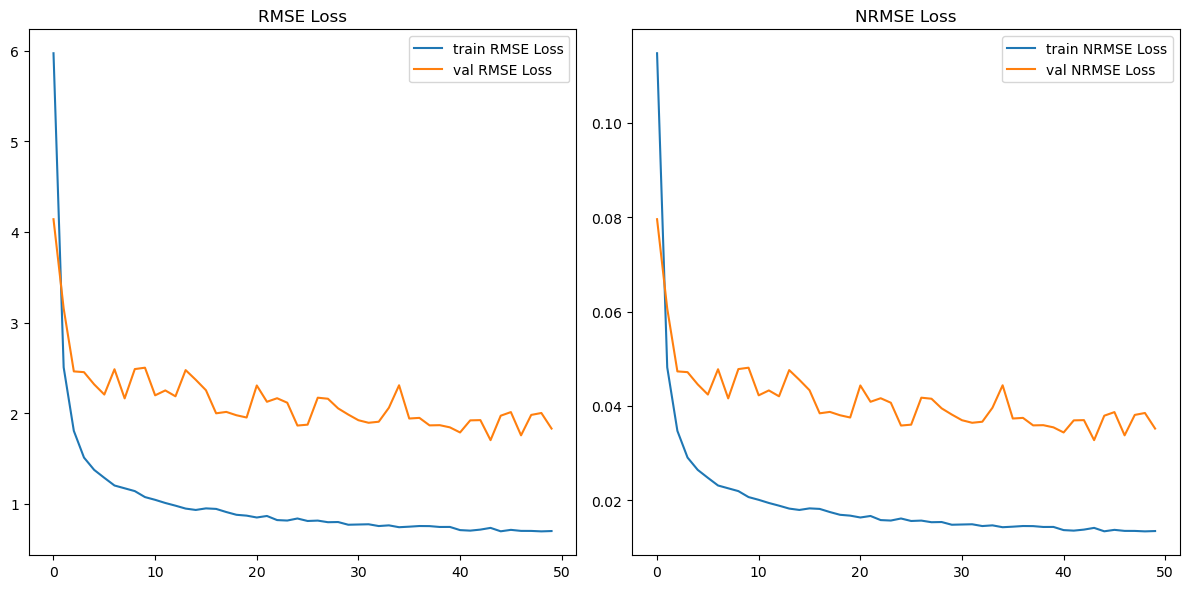

In [20]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
# plt.savefig('CAE_train_loss.png')  # 你可以更改文件名或格式
plt.show()


## Result

In [21]:
def draw_pic(x, y, coords):
    fig1, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=x[i, 0, :], cmap='bwr')
        axs[i].set_title(f'Input {i+1}')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=y[i, 0, :], cmap='bwr')
        axs[i].set_title(f'Predict {i+1}')
    plt.show()
    plt.close()


In [22]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
xycoords_check = np.load(xyfile)

In [23]:
model = Autoencoder(1, latent_space)
# 加载保存的状态字典
state_dict = torch.load('CAE.pth')
model.load_state_dict(state_dict)
model.to(device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout1): Dropout(p=0.1, inplace=False)
    (pool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(4, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout2): Dropout(p=0.1, inplace=False)
    (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(4, 1, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (leaky_relu): LeakyReLU(negative_slope=0.3)
    (dropout3): Dropout(p=0.1, inplace=False)
    (pool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (avg_pool): AdaptiveAvgPool1d(output_size=1000)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=1000, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (dense1): Linear(in_features=10, out_features=512, bias=True)

In [24]:
test_tensor = test_tensor.to(device)
input = preprocessor.transform(test_tensor)
y = model(input)
y = preprocessor.inverse_transform(y)
criterion = RMSELoss()
metric = NRMSE(test_tensor)

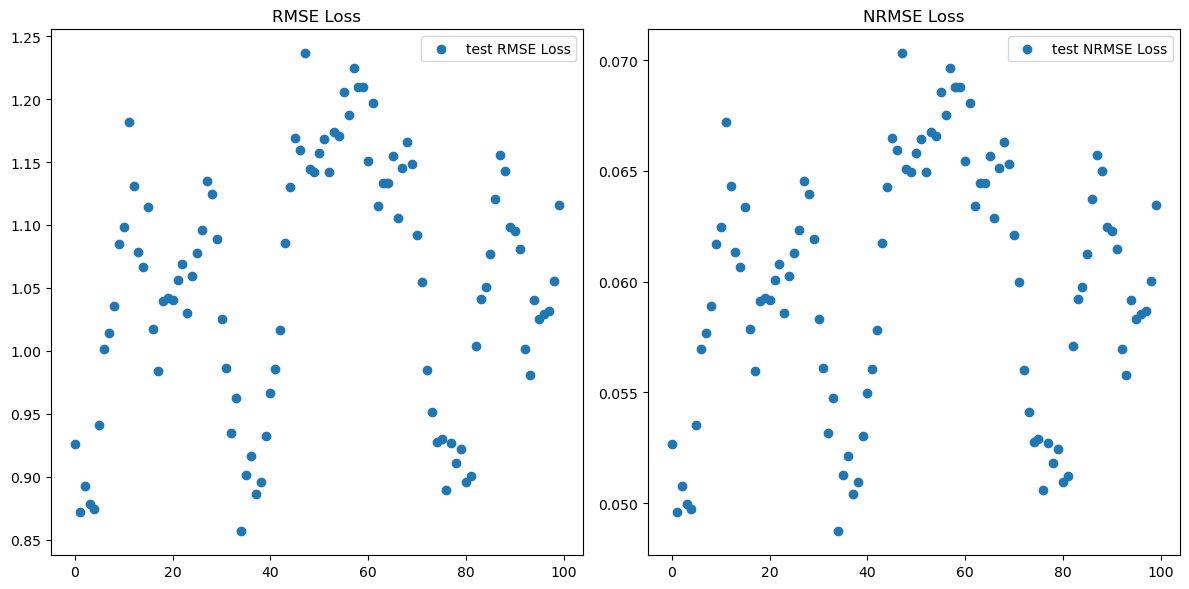

In [25]:
test_rmse=[]
test_nrmse=[]
for i in range(len(test_tensor)):
    nrmse = metric(test_tensor[i], y[i])
    rmse = criterion(test_tensor[i], y[i])

    test_rmse.append(rmse.cpu().detach().numpy())
    test_nrmse.append(nrmse.cpu().detach().numpy())


x = np.arange(0, 100)
test_rmse = np.array(test_rmse)
test_nrmse = np.array(test_nrmse)

# 保存数组到 .npy 文件
np.save('test_rmse.npy', test_rmse)
np.save('test_nrmse.npy', test_nrmse)

fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(x, test_rmse, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_nrmse, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠

# plt.savefig('CAE_test_loss.png')  # 你可以更改文件名或格式

plt.show()

In [26]:
y_np = y[:5].cpu().detach().numpy()
x_np = test_tensor[:5].cpu().detach().numpy()
rmse = criterion(test_tensor, y).item()
nrmse = metric(test_tensor, y).item()
print(f"Ave RMSE test loss: {rmse}")
print(f"Ave NRMSE test loss: {nrmse}")

Ave RMSE test loss: 1.0568127632141113
Ave NRMSE test loss: 0.06009821221232414


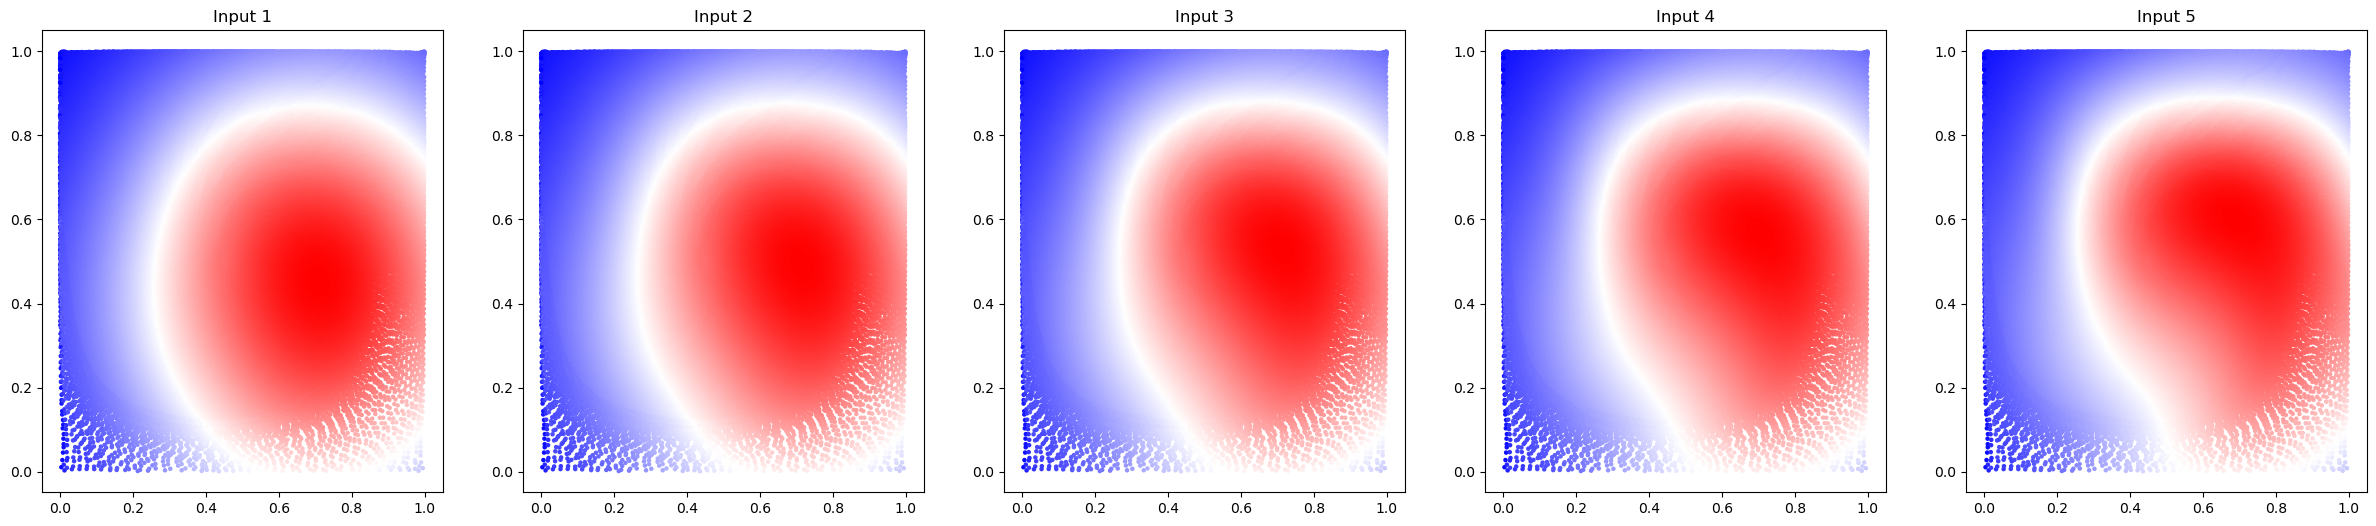

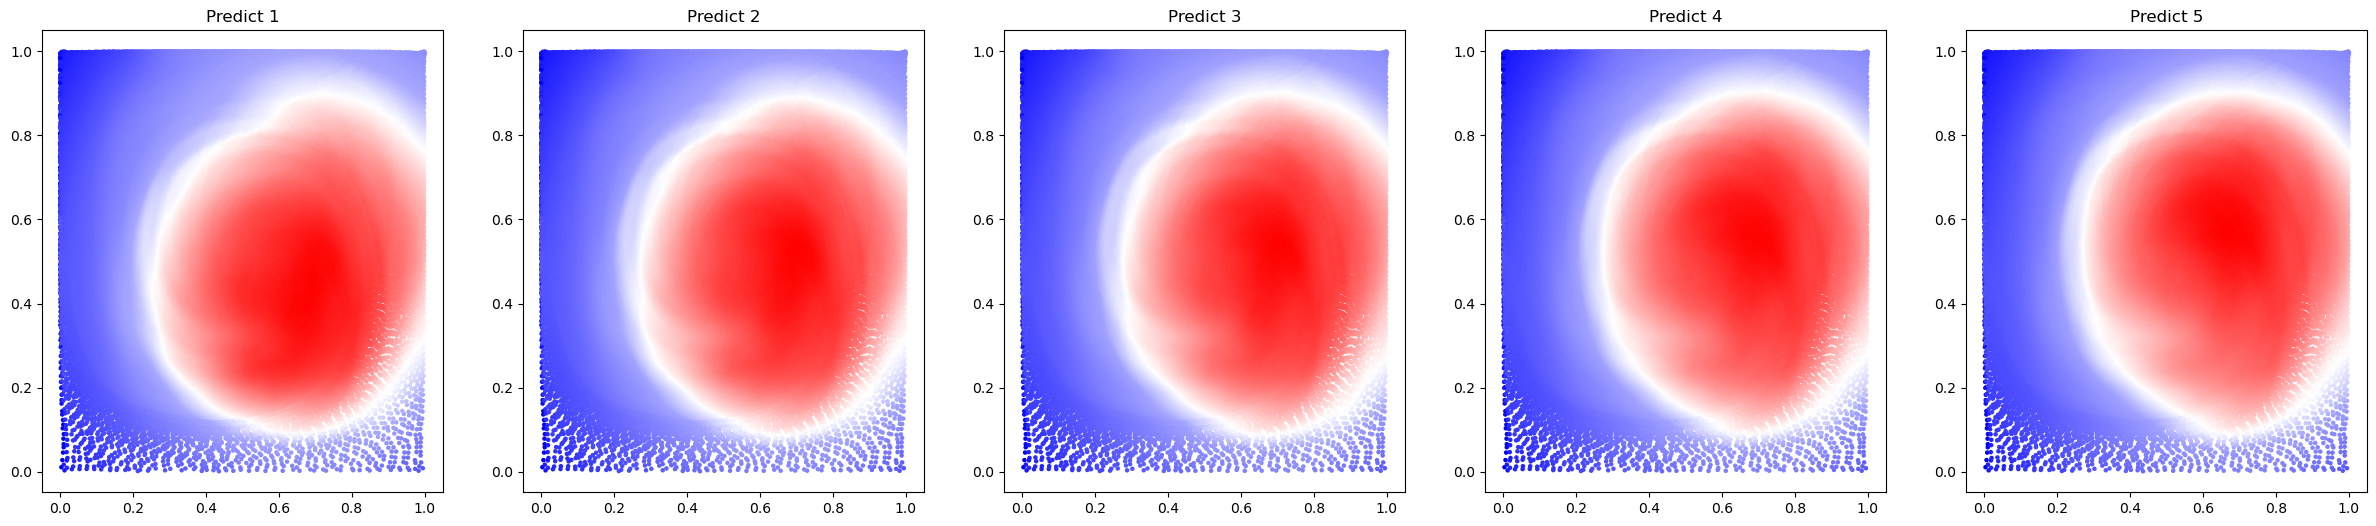

In [27]:
draw_pic(x_np, y_np, xycoords_check)